In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd


import contextily as ctx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

import libpysal as lp
from libpysal.weights import Queen, Rook, KNN, Kernel
import mapclassify as mc
from pysal.viz import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster
import esda
from splot.esda import plot_local_autocorrelation

import mapclassify

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

gpd.__version__

'0.7.0'

# Reading county data

In [ ]:
url='https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/tigerWMS_ACS2019/MapServer/86/query?\
where=STATE%3C57\
&geometryType=esriGeometryEnvelope\
&spatialRel=esriSpatialRelIntersects\
&outFields=GEOID%2C+STATE%2CCOUNTY%2CBASENAME\
&returnGeometry=true\
&returnTrueCurves=false\
&returnIdsOnly=false\
&returnCountOnly=false\
&returnZ=false\
&returnM=false\
&returnDistinctValues=false\
&returnDistinctValues=false\
&returnExtentsOnly=false\
&f=geojson'
%time county=gpd.read_file(url)
print('Number of records={}'.format(county.shape[0]))
county.plot(column='STATE',figsize=(12,15));

# Reading regional data

Wall time: 10.4 s
Number of records=4


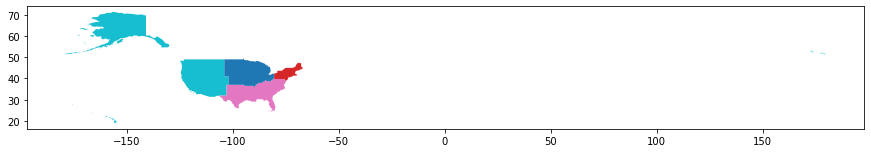

In [2]:
rurl='https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Region_Division/MapServer/1/query?\
where=AREALAND%3E0\
&geometryType=esriGeometryEnvelope\
&spatialRel=esriSpatialRelIntersects\
&returnGeometry=true\
&returnTrueCurves=false\
&returnIdsOnly=false\
&returnCountOnly=false\
&returnZ=false\
&returnM=false\
&returnDistinctValues=false\
&returnExtentsOnly=false\
&f=geojson'
%time region=gpd.read_file(rurl)
print('Number of records={}'.format(region.shape[0]))
region.plot(column='BASENAME',figsize=(15,15));

# Saving counties and region map to file

In [ ]:
county.to_file('Contig_counties.geojson', driver = 'GeoJSON')

In [ ]:
region.to_file('Contig_region.geojson', driver = 'GeoJSON')

# Importing locally saved file

In [3]:
county = gpd.read_file('Contig_counties.geojson')

In [ ]:
region = gpd.read_file('Contig_region.geojson')

# Remove Alaska and Hawaii to find contiguous US

In [4]:
#Remove Alaska and Hawaii
new_county = county.loc[~((county.STATE == '02')|(county.STATE == '15')),:]

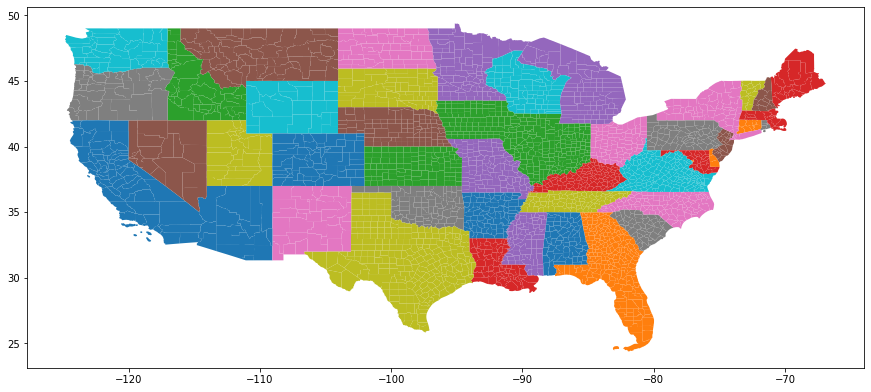

In [5]:
new_county.plot(column = 'STATE', figsize = (15,15));

In [6]:
states = new_county.dissolve(by = 'STATE')
states['centroids'] = states.centroid
states = states.set_geometry('centroids')
stByReg = gpd.sjoin(states, region, how = 'inner', op = 'intersects')
stByReg = stByReg.rename(columns = {'index_right':'Region', 'BASENAME_right':'Reg_Name'})
fields = ['Region', 'Reg_Name']
stByReg = stByReg[fields].copy()
stByReg.tail()

,Region,Reg_Name
STATE,,
31,3,Midwest
38,3,Midwest
39,3,Midwest
46,3,Midwest
55,3,Midwest


In [7]:
#keep all the county polygons in the contiguous US
counties = pd.merge(new_county, stByReg, on = 'STATE', how = 'left')
counties.tail()

,GEOID,STATE,COUNTY,BASENAME,geometry,Region,Reg_Name
3103,28143,28,143,Tunica,"POLYGON ((-90.45172 34.74212, -90.45176 34.741...",0,South
3104,29081,29,081,Harrison,"POLYGON ((-94.21462 40.47046, -94.21462 40.470...",3,Midwest
3105,18005,18,005,Bartholomew,"POLYGON ((-86.08168 39.21938, -86.08168 39.219...",3,Midwest
3106,13223,13,223,Paulding,"POLYGON ((-84.96942 33.97350, -84.96944 33.973...",0,South
3107,39015,39,015,Brown,"POLYGON ((-84.03663 38.89514, -84.03670 38.894...",3,Midwest


# Project layers and map.

In [8]:
# USA Contiguous Albers Equal Area Conic - units = meters
counties = counties.to_crs('ESRI:102003')
region = region.to_crs('ESRI:102003')

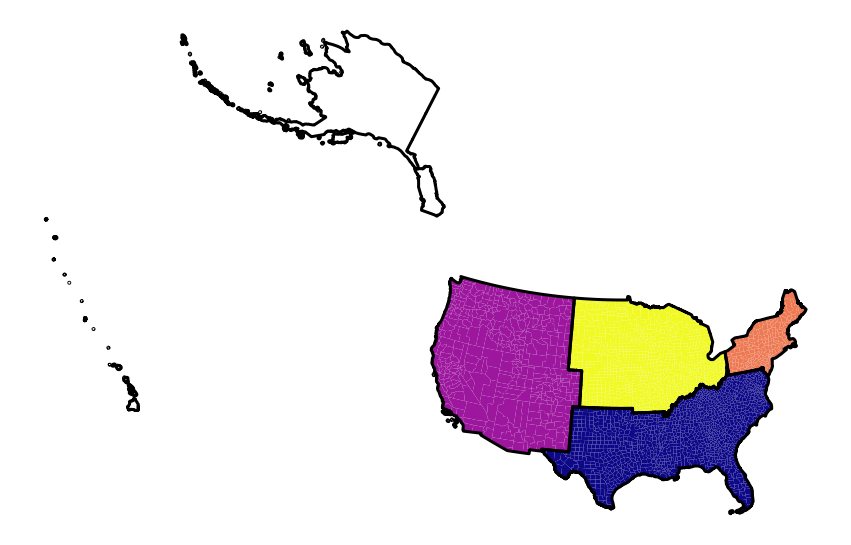

In [9]:
fig,ax = plt.subplots(figsize = (15, 15), subplot_kw = dict(aspect = 'equal'))
counties.plot(column = 'Region', cmap = 'plasma', ax = ax);
region.plot(facecolor = 'none', edgecolor = 'k', linewidth = 3, ax = ax);
ax.set_axis_off()
plt.show()

# Get COVID 19 data

In [ ]:
colslist = ['countyFIPS', 'County Name', 'State', 'stateFIPS', '4/15/20', '5/15/20', '6/15/20']
caseurl = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv'
casedf = pd.read_csv(caseurl, usecols = colslist)
casedf.tail()

In [ ]:
casedf.loc[(casedf.countyFIPS == 0)|(casedf.countyFIPS == 1)].tail()

In [ ]:
casedf = casedf.loc[~((casedf.countyFIPS == 0)|(casedf.countyFIPS == 1)),:]
casedf.shape

In [ ]:
popurl = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv'
popdf = pd.read_csv(popurl)
popdf.tail()

In [ ]:
popdf = popdf.loc[~((popdf.countyFIPS == 0)|(popdf.countyFIPS == 1)),:]
popdf.shape

In [ ]:
jdf = casedf.merge(popdf, on = 'countyFIPS')
fields = ['countyFIPS', 'County Name_x', 'State_x', 'stateFIPS', '4/15/20', '5/15/20', '6/15/20', 'population']
jdf = jdf[fields]
jdf = jdf.rename(columns = {'County Name_x':'County Name', 'State_x':'State'})
jdf.head()

# Join attribute table to spatial data (county boundaries)

In [ ]:
jdf['countyFIPS'] = jdf['countyFIPS'].astype(str)
jdf['stateFIPS'] = jdf['stateFIPS'].astype(int)
jdf['geoid'] = jdf['countyFIPS']
jdf.loc[jdf.stateFIPS < 10, 'geoid'] = '0' + jdf['countyFIPS']
jdf.head()

In [ ]:
co_gdf = counties.merge(jdf, left_on = 'GEOID', right_on = 'geoid')
co_gdf.tail()

# Calculate cases per 100,000 population

In [ ]:
co_gdf['April_PC'] = co_gdf['4/15/20']/(co_gdf['population']/100000)
co_gdf['May_PC'] = co_gdf['5/15/20']/(co_gdf['population']/100000)
co_gdf['June_PC'] = co_gdf['6/15/20']/(co_gdf['population']/100000)
co_gdf[['April_PC', 'May_PC', 'June_PC']]

In [ ]:
reg1 = co_gdf.loc[co_gdf.Region == 0].copy()
reg2 = co_gdf.loc[co_gdf.Region == 1].copy()
reg3 = co_gdf.loc[co_gdf.Region == 2].copy()
reg4 = co_gdf.loc[co_gdf.Region == 3].copy()

In [ ]:
print('Number of counties in the contiguous US: ', co_gdf.Region.count())
print('counties in region 1: ', reg1.Region.count())
print('counties in region 2: ', reg2.Region.count())
print('counties in region 3: ', reg3.Region.count())
print('counties in region 4: ', reg4.Region.count())

# Spatial Autocorrelation Analysis  Completed Using This Geodataframe

In [ ]:
def getweights(geodf):
    qws = lp.weights.Queen.from_dataframe(geodf)
    qws.transform = 'r'
    return qws

dbs = [co_gdf, reg1, reg2, reg3, reg4]
qw_list = [df.pipe(getweights) for df in dbs]
qw_list

# Queen Spatial Weights

In [ ]:
print('Cont. US: ', getweights(co_gdf).histogram)

In [ ]:
print('Region 1: ', getweights(reg1).histogram)

In [ ]:
print('Region 2: ', getweights(reg2).histogram)

In [ ]:
print('Region 3: ', getweights(reg3).histogram)

In [ ]:
print('Region 4: ', getweights(reg4).histogram)

# Contiguous US Analysis

In [ ]:
def spAutoAnal (geodf, varstr, qw_df):
    y = geodf[varstr].astype(float)
    mi = esda.moran.Moran(y, qw_df)
    li = esda.moran.Moran_Local(y, qw_df)
    return(mi, li)

In [ ]:
varlist = ['April_PC', 'May_PC', 'June_PC']
res_list = []
i = 0
for df in dbs:
    for varl in varlist:
        results = spAutoAnal(geodf = df, varstr = varl, qw_df = qw_list[i])
        res_list.append(results)
    i += 1
print(res_list[0][0])

# Global Moran's I for contiguous US and 4 regions

In [ ]:
Morans_dict = {'Contiguous_US':[res_list[0][0].I, res_list[1][0].I, res_list[2][0].I],
            'Region_1':[res_list[3][0].I, res_list[4][0].I, res_list[5][0].I],
            'Region_2':[res_list[6][0].I, res_list[7][0].I, res_list[8][0].I],
            'Region_3':[res_list[9][0].I, res_list[10][0].I, res_list[11][0].I],
            'Region_4':[res_list[12][0].I, res_list[13][0].I, res_list[14][0].I]}

Moransdf = pd.DataFrame.from_dict(Morans_dict, orient = 'index')
Moransdf.columns = ['April_PC','May_PC','June_PC']
Moransdf

# Local Moran's for Hot and Cold

## Local Moran's for Contiguous US for April, May, and June respectively

In [ ]:
licap = res_list[0][1]
licma = res_list[1][1]
licju = res_list[2][1]

## Local Moran's for Region 1 for April, May, and June respectively

In [ ]:
lireg1ap = res_list[3][1]
lireg1ma = res_list[4][1]
lireg1ju = res_list[5][1]

## Local Moran's for Region 2 for April, May, and June respectively

In [ ]:
lireg2ap = res_list[6][1]
lireg2ma = res_list[7][1]
lireg2ju = res_list[8][1]

## Local Moran's for Region 3 for April, May, and June respectively

In [ ]:
lireg3ap = res_list[9][1]
lireg3ma = res_list[10][1]
lireg3ju = res_list[11][1]

## Local Moran's for Region 4 for April, May, and June respectively

In [ ]:
lireg4ap = res_list[12][1]
lireg4ma = res_list[13][1]
lireg4ju = res_list[14][1]

## Hot and Cold Spots for Contiguous US in April

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = licap.p_sim < 0.05

hotspot95_li = sig95_li*licap.q == 1
coldspot95_li = sig95_li*licap.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_usa = co_gdf.assign(hs = hlabels95_li)
cs_usa = co_gdf.assign(cs = clabels95_li)

hs_usa_april = hs_usa.loc[hs_usa['hs'] == 'hot spot', 'hs'].count()
cs_usa_april = cs_usa.loc[cs_usa['cs'] == 'cold spot', 'cs'].count()

print('Contiguous US Hot Spots in April: ', hs_usa_april)
print('Contiguous US Cold Spots in April: ', cs_usa_april)

## Hot and Cold Spots for Contiguous US in May

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = licma.p_sim < 0.05

hotspot95_li = sig95_li*licma.q == 1
coldspot95_li = sig95_li*licma.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_usa = co_gdf.assign(hs = hlabels95_li)
cs_usa = co_gdf.assign(cs = clabels95_li)

hs_usa_may = hs_usa.loc[hs_usa['hs'] == 'hot spot', 'hs'].count()
cs_usa_may = cs_usa.loc[cs_usa['cs'] == 'cold spot', 'cs'].count()

print('Contiguous US Hot Spots in May: ', hs_usa_may)
print('Contiguous US Cold Spots in May: ', cs_usa_may)

## Hot and Cold Spots for Contiguous US in June

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = licju.p_sim < 0.05

hotspot95_li = sig95_li*licju.q == 1
coldspot95_li = sig95_li*licju.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_usa = co_gdf.assign(hs = hlabels95_li)
cs_usa = co_gdf.assign(cs = clabels95_li)

hs_usa_june = hs_usa.loc[hs_usa['hs'] == 'hot spot', 'hs'].count()
cs_usa_june = cs_usa.loc[cs_usa['cs'] == 'cold spot', 'cs'].count()

print('Contiguous US Hot Spots in June: ', hs_usa_june)
print('Contiguous US Cold Spots in June: ', cs_usa_june)

## Hot and Cold Spots for Region 1 in April

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg1ap.p_sim < 0.05

hotspot95_li = sig95_li*lireg1ap.q == 1
coldspot95_li = sig95_li*lireg1ap.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg1 = reg1.assign(hs = hlabels95_li)
cs_reg1 = reg1.assign(cs = clabels95_li)

hs_reg1_april = hs_reg1.loc[hs_reg1['hs'] == 'hot spot', 'hs'].count()
cs_reg1_april = cs_reg1.loc[cs_reg1['cs'] == 'cold spot', 'cs'].count()

print('Region 1 Hot Spots in April: ', hs_reg1_april)
print('Region 1 Cold Spots in April: ', cs_reg1_april)

## Hot and Cold Spots for Region 1 in May

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg1ma.p_sim < 0.05

hotspot95_li = sig95_li*lireg1ma.q == 1
coldspot95_li = sig95_li*lireg1ma.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg1 = reg1.assign(hs = hlabels95_li)
cs_reg1 = reg1.assign(cs = clabels95_li)

hs_reg1_may = hs_reg1.loc[hs_reg1['hs'] == 'hot spot', 'hs'].count()
cs_reg1_may = cs_reg1.loc[cs_reg1['cs'] == 'cold spot', 'cs'].count()

print('Region 1 Hot Spots in May: ', hs_reg1_may)
print('Region 1 Cold Spots in May: ', cs_reg1_may)

## Hot and Cold Spots for Region 1 in June

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg1ju.p_sim < 0.05

hotspot95_li = sig95_li*lireg1ju.q == 1
coldspot95_li = sig95_li*lireg1ju.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg1 = reg1.assign(hs = hlabels95_li)
cs_reg1 = reg1.assign(cs = clabels95_li)

hs_reg1_june = hs_reg1.loc[hs_reg1['hs'] == 'hot spot', 'hs'].count()
cs_reg1_june = cs_reg1.loc[cs_reg1['cs'] == 'cold spot', 'cs'].count()

print('Region 1 Hot Spots in June: ', hs_reg1_june)
print('Region 1 Cold Spots in June: ', cs_reg1_june)

## Hot and Cold Spots for Region 2 in April

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg2ap.p_sim < 0.05

hotspot95_li = sig95_li*lireg2ap.q == 1
coldspot95_li = sig95_li*lireg2ap.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg2 = reg2.assign(hs = hlabels95_li)
cs_reg2 = reg2.assign(cs = clabels95_li)

hs_reg2_april = hs_reg2.loc[hs_reg2['hs'] == 'hot spot', 'hs'].count()
cs_reg2_april = cs_reg2.loc[cs_reg2['cs'] == 'cold spot', 'cs'].count()

print('Region 2 Hot Spots in April: ', hs_reg2_april)
print('Region 2 Cold Spots in April: ', cs_reg2_april)

## Hot and Cold Spots for Region 2 in May

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg2ma.p_sim < 0.05

hotspot95_li = sig95_li*lireg2ma.q == 1
coldspot95_li = sig95_li*lireg2ma.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg2 = reg2.assign(hs = hlabels95_li)
cs_reg2 = reg2.assign(cs = clabels95_li)

hs_reg2_may = hs_reg2.loc[hs_reg2['hs'] == 'hot spot', 'hs'].count()
cs_reg2_may = cs_reg2.loc[cs_reg2['cs'] == 'cold spot', 'cs'].count()

print('Region 2 Hot Spots in May: ', hs_reg2_may)
print('Region 2 Cold Spots in May: ', cs_reg2_may)

## Hot and Cold Spots for Region 2 in June

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg2ju.p_sim < 0.05

hotspot95_li = sig95_li*lireg2ju.q == 1
coldspot95_li = sig95_li*lireg2ju.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg2 = reg2.assign(hs = hlabels95_li)
cs_reg2 = reg2.assign(cs = clabels95_li)

hs_reg2_june = hs_reg2.loc[hs_reg2['hs'] == 'hot spot', 'hs'].count()
cs_reg2_june = cs_reg2.loc[cs_reg2['cs'] == 'cold spot', 'cs'].count()

print('Region 2 Hot Spots in June: ', hs_reg2_june)
print('Region 2 Cold Spots in June: ', cs_reg2_june)

## Hot and Cold Spots for Region 3 in April

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg3ap.p_sim < 0.05

hotspot95_li = sig95_li*lireg3ap.q == 1
coldspot95_li = sig95_li*lireg3ap.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg3 = reg3.assign(hs = hlabels95_li)
cs_reg3 = reg3.assign(cs = clabels95_li)

hs_reg3_april = hs_reg3.loc[hs_reg3['hs'] == 'hot spot', 'hs'].count()
cs_reg3_april = cs_reg3.loc[cs_reg3['cs'] == 'cold spot', 'cs'].count()

print('Region 3 Hot Spots in April: ', hs_reg3_april)
print('Region 3 Cold Spots in April: ', cs_reg3_april)

## Hot and Cold Spots for Region 3 in May

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg3ma.p_sim < 0.05

hotspot95_li = sig95_li*lireg3ma.q == 1
coldspot95_li = sig95_li*lireg3ma.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg3 = reg3.assign(hs = hlabels95_li)
cs_reg3 = reg3.assign(cs = clabels95_li)

hs_reg3_may = hs_reg3.loc[hs_reg3['hs'] == 'hot spot', 'hs'].count()
cs_reg3_may = cs_reg3.loc[cs_reg3['cs'] == 'cold spot', 'cs'].count()

print('Region 3 Hot Spots in May: ', hs_reg3_may)
print('Region 3 Cold Spots in May: ', cs_reg3_may)

## Hot and Cold Spots for Region 3 in June

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg3ju.p_sim < 0.05

hotspot95_li = sig95_li*lireg3ju.q == 1
coldspot95_li = sig95_li*lireg3ju.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg3 = reg3.assign(hs = hlabels95_li)
cs_reg3 = reg3.assign(cs = clabels95_li)

hs_reg3_june = hs_reg3.loc[hs_reg3['hs'] == 'hot spot', 'hs'].count()
cs_reg3_june = cs_reg3.loc[cs_reg3['cs'] == 'cold spot', 'cs'].count()

print('Region 3 Hot Spots in June: ', hs_reg3_june)
print('Region 3 Cold Spots in June: ', cs_reg3_june)

## Hot and Cold Spots for Region 4 in April

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg4ap.p_sim < 0.05

hotspot95_li = sig95_li*lireg4ap.q == 1
coldspot95_li = sig95_li*lireg4ap.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg4 = reg4.assign(hs = hlabels95_li)
cs_reg4 = reg4.assign(cs = clabels95_li)

hs_reg4_april = hs_reg4.loc[hs_reg4['hs'] == 'hot spot', 'hs'].count()
cs_reg4_april = cs_reg4.loc[cs_reg4['cs'] == 'cold spot', 'cs'].count()

print('Region 4 Hot Spots in April: ', hs_reg4_april)
print('Region 4 Cold Spots in April: ', cs_reg4_april)

## Hot and Cold Spots for Region 4 in May

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg4ma.p_sim < 0.05

hotspot95_li = sig95_li*lireg4ma.q == 1
coldspot95_li = sig95_li*lireg4ma.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg4 = reg4.assign(hs = hlabels95_li)
cs_reg4 = reg4.assign(cs = clabels95_li)

hs_reg4_may = hs_reg4.loc[hs_reg4['hs'] == 'hot spot', 'hs'].count()
cs_reg4_may = cs_reg4.loc[cs_reg4['cs'] == 'cold spot', 'cs'].count()

print('Region 4 Hot Spots in May: ', hs_reg4_may)
print('Region 4 Cold Spots in May: ', cs_reg4_may)

## Hot and Cold Spots for Region 4 in June

In [ ]:
hspots = ['n.sig.', 'hot spot']
cspots = ['n.sig.', 'cold spot']

sig95_li = lireg4ju.p_sim < 0.05

hotspot95_li = sig95_li*lireg4ju.q == 1
coldspot95_li = sig95_li*lireg4ju.q == 3

hlabels95_li = [hspots[i] for i in hotspot95_li*1]
clabels95_li = [cspots[i] for i in coldspot95_li*1]

hs_reg4 = reg4.assign(hs = hlabels95_li)
cs_reg4 = reg4.assign(cs = clabels95_li)

hs_reg4_june = hs_reg4.loc[hs_reg4['hs'] == 'hot spot', 'hs'].count()
cs_reg4_june = cs_reg4.loc[cs_reg4['cs'] == 'cold spot', 'cs'].count()

print('Region 4 Hot Spots in June: ', hs_reg4_june)
print('Region 4 Cold Spots in June: ', cs_reg4_june)

# Hot and Cold spots (at 95% confidence) for contiguous US and regions

In [ ]:
print('Contiguous US Hot Spots in April:', hs_usa_april)
print('Contiguous US Hot Spots in May:', hs_usa_may)
print('Contiguous US Hot Spots in June:', hs_usa_june)
print('Contiguous US Cold Spots in April:', cs_usa_april)
print('Contiguous US Cold Spots in May:', cs_usa_may)
print('Contiguous US Cold Spots in June:', cs_usa_june)
print('')
print('Region 1 Hot Spots in April:', hs_reg1_april)
print('Region 1 Hot Spots in May:', hs_reg1_may)
print('Region 1 Hot Spots in June:', hs_reg1_june)
print('Region 1 Cold Spots in April:', cs_reg1_april)
print('Region 1 Cold Spots in May:', cs_reg1_may)
print('Region 1 Cold Spots in June:', cs_reg1_june)
print('')
print('Region 2 Hot Spots in April:', hs_reg2_april)
print('Region 2 Hot Spots in May:', hs_reg2_may)
print('Region 2 Hot Spots in June:', hs_reg2_june)
print('Region 2 Cold Spots in April:', cs_reg2_april)
print('Region 2 Cold Spots in May:', cs_reg2_may)
print('Region 2 Cold Spots in June:', cs_reg2_june)
print('')
print('Region 3 Hot Spots in April:', hs_reg3_april)
print('Region 3 Hot Spots in May:', hs_reg3_may)
print('Region 3 Hot Spots in June:', hs_reg3_june)
print('Region 3 Cold Spots in April:', cs_reg3_april)
print('Region 3 Cold Spots in May:', cs_reg3_may)
print('Region 3 Cold Spots in June:', cs_reg3_june)
print('')
print('Region 4 Hot Spots in April:', hs_reg4_april)
print('Region 4 Hot Spots in May:', hs_reg4_may)
print('Region 4 Hot Spots in June:', hs_reg4_june)
print('Region 4 Cold Spots in April:', cs_reg4_april)
print('Region 4 Cold Spots in May:', cs_reg4_may)
print('Region 4 Cold Spots in June:', cs_reg4_june)

# Interpret the results

## Do the Global Moran's I indicate clustering? By study area and time.

From the table for Global Moran's I above, there are only five situations where the Global Moran's I indicate clustering (that is, an I value of greater than 0.393. Those situations are as follows:

Contiguous US Global Moran's I in April = 0.637 > I = 0.393<br>
Region 1 Global Moran's I in April = 0.582 > I = 0.393<br>
Region 3 Global Moran's I in April = 0.768 > I = 0.393<br>
Region 3 Global Moran's I in May = 0.780 > I = 0.393<br>
Region 3 Global Moran's I in June = 0.776 > I = 0.393<br>

The remaining circumstances for Contiguous US (May and June), Region 1 (May and June), all of Region 2, and all of Region 4 don't show significant clustering (have an I value less than 0.393.

## How do the hot and cold spots vary over time and study area?

Note: Every change of values will go from April to May to June.

From the hot and cold spots from above, we can see that for the Contiguous US, the number of hot spots went from 156 to 202 to 237 and the number of cold spots went from 648 to 673 to 694. For Region 1, hot spots went from 71 to 108 to 117 while cold spots went from 292 to 328 to 324. In Region 2, hot spots change from 21 to 20 to 24 and cold spots change from 62 to 70 to 63. For Region 3, hot spots varied from 23 to 31 to 36 while cold spots changed from 55 to 64 to 61. Finally, Region 4 started with 76 to 40 to 43 and cold spots went from 165 to 217 to 210.

For such a small sample size, the most obvious trend for time is the growth in overall hot spots and cold spots. For hot spots, the spread of the disease seems apparent. For cold spots, I would assume more data was being collected which lead to this realization.

For study area, every region followed a similar trend as the overall numbers besides Region 4. Region 4 started with 76 hot spots and in June had 43.

# Interactive map showing counties in the contiguous US that are hot spots for all three dates considered and cold spots for all three dates considered.

# Get colors for map

In [ ]:
def getcolor(cv, locM, df, cname):
    
    sig = cname + 'significant'
    df[sig] = locM.p_sim < cv
    
    quad = cname + 'quadrant'
    df[quad] = locM.q
    
    colors = cname + '_col'
    df[colors] = 'gray'
    df.loc[(df[quad] == 1) & (df[sig] == True), colors] = 'red'
    df.loc[(df[quad] == 2) & (df[sig] == True), colors] = '#83cef4'
    df.loc[(df[quad] == 3) & (df[sig] == True), colors] = 'blue'
    df.loc[(df[quad] == 4) & (df[sig] == True), colors] = '#e59696'
    
    types = cname + '_type'
    df[types] = 'N. Sig.'
    df.loc[(df[quad] == 1) & (df[sig] == True), types] = 'Hot Spot'
    df.loc[(df[quad] == 2) & (df[sig] == True), types] = 'Low-High'
    df.loc[(df[quad] == 3) & (df[sig] == True), types] = 'Cold Spot'
    df.loc[(df[quad] == 4) & (df[sig] == True), types] = 'High-Low'
    
    return df

In [ ]:
i = 0
for df in dbs:
    k = 0
    for varl in varlist:
        getcolor(cv = 0.05, locM = res_list[i][1], df = df, cname = varlist[k])
        i += 1
        k += 1

# Contiguous US for all hot and all cold for all dates

In [ ]:
co_gdfallHot = co_gdf.loc[(co_gdf.April_PC_type == 'Hot Spot') & (co_gdf.May_PC_type == 'Hot Spot') & (co_gdf.June_PC_type == 'Hot Spot')]
co_gdfallCold = co_gdf.loc[(co_gdf.April_PC_type == 'Cold Spot') & (co_gdf.May_PC_type == 'Cold Spot') & (co_gdf.June_PC_type == 'Cold Spot')]
co_gdfallHot.shape[0], co_gdfallCold.shape[0]

# Region 1 for all hot and all cold for all dates

In [ ]:
reg1allHot = reg1.loc[(reg1.April_PC_type == 'Hot Spot') & (reg1.May_PC_type == 'Hot Spot') & (reg1.June_PC_type == 'Hot Spot')]
reg1allCold = reg1.loc[(reg1.April_PC_type == 'Cold Spot') & (reg1.May_PC_type == 'Cold Spot') & (reg1.June_PC_type == 'Cold Spot')]
reg1allHot.shape[0], reg1allCold.shape[0]

# Region 2 for all hot and all cold for all dates

In [ ]:
reg2allHot = reg2.loc[(reg2.April_PC_type == 'Hot Spot') & (reg2.May_PC_type == 'Hot Spot') & (reg2.June_PC_type == 'Hot Spot')]
reg2allCold = reg2.loc[(reg2.April_PC_type == 'Cold Spot') & (reg2.May_PC_type == 'Cold Spot') & (reg2.June_PC_type == 'Cold Spot')]
reg2allHot.shape[0], reg2allCold.shape[0]

# Region 3 for all hot and all cold for all dates

In [ ]:
reg3allHot = reg3.loc[(reg3.April_PC_type == 'Hot Spot') & (reg3.May_PC_type == 'Hot Spot') & (reg3.June_PC_type == 'Hot Spot')]
reg3allCold = reg3.loc[(reg3.April_PC_type == 'Cold Spot') & (reg3.May_PC_type == 'Cold Spot') & (reg3.June_PC_type == 'Cold Spot')]
reg3allHot.shape[0], reg3allCold.shape[0]

# Region 4 for all hot and all cold for all dates

In [ ]:
reg4allHot = reg4.loc[(reg4.April_PC_type == 'Hot Spot') & (reg4.May_PC_type == 'Hot Spot') & (reg4.June_PC_type == 'Hot Spot')]
reg4allCold = reg4.loc[(reg4.April_PC_type == 'Cold Spot') & (reg4.May_PC_type == 'Cold Spot') & (reg4.June_PC_type == 'Cold Spot')]
reg4allHot.shape[0], reg4allCold.shape[0]

In [ ]:
totall = [{'Hot Spots': co_gdfallHot.GEOID.count(), 'Cold Spots': co_gdfallCold.GEOID.count()}, 
          {'Hot Spots': reg1allHot.GEOID.count(), 'Cold Spots': reg1allCold.GEOID.count()},
          {'Hot Spots': reg2allHot.GEOID.count(), 'Cold Spots': reg2allCold.GEOID.count()},
          {'Hot Spots': reg3allHot.GEOID.count(), 'Cold Spots': reg3allCold.GEOID.count()},
          {'Hot Spots': reg4allHot.GEOID.count(), 'Cold Spots': reg4allCold.GEOID.count()}
         ]

totallcount = pd.DataFrame(totall, index = ['Contiguous_US', 'Region 1', 'Region 2', 'Region 3', 'Region 4'])
totallcount

# Comparing Region 2 to the Contiguous US

In [ ]:
reg2n = reg2[['GEOID','April_PC_type','May_PC_type','June_PC_type']]
counties = co_gdf[['GEOID','geometry','April_PC_type','May_PC_type','June_PC_type']]
reg2all = pd.merge(counties, reg2n, left_on = 'GEOID', right_on = 'GEOID')
reg2all.tail()

## April color dataset

In [ ]:
AprUSdf = co_gdf[['geoid', 'geometry', 'Reg_Name', 'County Name', 'State', '4/15/20', 'April_PC']].copy()
tdf1 = getcolor(0.05, licap, AprUSdf, 'April_PC')
tdf1.head()

## May color dataset

In [ ]:
MayUSdf = co_gdf[['geoid', 'geometry', 'Reg_Name', 'County Name', 'State', '5/15/20', 'May_PC']].copy()
tdf2 = getcolor(0.05, licma, MayUSdf, 'May_PC')
tdf2.head()

## June color dataset

In [ ]:
JunUSdf = co_gdf[['geoid', 'geometry', 'Reg_Name', 'County Name', 'State', '6/15/20', 'June_PC']].copy()
tdf3 = getcolor(0.05, licju, JunUSdf, 'June_PC')
tdf3.head()

# Creating Variable Sizes for Future Bokeh Plotting

In [ ]:
BGp1 =tdf1
BGp1['centroids'] = BGp1['geometry'].centroid
BGp1 = BGp1.set_geometry('centroids')
BGp1 = BGp1.drop('geometry', axis = 1)

BGp2 = tdf2
BGp2['centroids'] = BGp2['geometry'].centroid
BGp2 = BGp2.set_geometry('centroids')
BGp2 = BGp2.drop('geometry', axis = 1)

BGp3 = tdf3
BGp3['centroids'] = BGp3['geometry'].centroid
BGp3 = BGp3.set_geometry('centroids')
BGp3 = BGp3.drop('geometry', axis = 1)

In [ ]:
import mapclassify as mc

april = BGp1.loc[BGp1.April_PC > 0].reset_index()
ks = mc.classifiers.KClassifiers(april['April_PC'])
ks.best.name, ks.best.k

may = BGp2.loc[BGp2.May_PC > 0].reset_index()
ks = mc.classifiers.KClassifiers(may['May_PC'])
ks.best.name, ks.best.k

june = BGp3.loc[BGp3.June_PC > 0].reset_index()
ks = mc.classifiers.KClassifiers(june['June_PC'])
ks.best.name, ks.best.k

In [ ]:
fj7_1 = mc.FisherJenks(april['April_PC'], k = 5)
april = april[['geoid', 'centroids', 'April_PC', 'April_PC_col', 'April_PC_type']].copy()

fj7_2 = mc.FisherJenks(may['May_PC'], k = 5)
may = may[['geoid', 'centroids', 'May_PC', 'May_PC_col', 'May_PC_type']].copy()

fj7_3 = mc.FisherJenks(june['June_PC'], k = 5)
june = june[['geoid', 'centroids', 'June_PC', 'June_PC_col', 'June_PC_type']].copy()

In [ ]:
april['bins'] = fj7_1.yb
april['csize'] = april['bins']*1
april['csize'] = april['csize'].round(0).astype(int)
april.head()

In [ ]:
april.shape

In [ ]:
may['bins'] = fj7_2.yb
may['csize'] = may['bins']*1
may['csize'] = may['csize'].round(0).astype(int)
may.head()

In [ ]:
may.shape

In [ ]:
june['bins'] = fj7_3.yb
june['csize'] = june['bins']*1
june['csize'] = june['csize'].round(0).astype(int)
june.head()

In [ ]:
june.shape

In [ ]:
minside1 = 3
april['csizep'] = ((april['bins'] + 1)*minside1)
april['csizep'] = april['csizep'].round(0).astype(int)

minside2 = 3
may['csizep'] = ((may['bins'] + 1)*minside2)
may['csizep'] = may['csizep'].round(0).astype(int)

minside3 = 3
june['csizep'] = ((june['bins'] + 1)*minside3)
june['csizep'] = june['csizep'].round(0).astype(int)

# Merged DataFrame

In [ ]:
co_gdfallHot.columns
hotfiltered = ['geoid', 'June_PC_col', 'June_PC_type']
allhot = co_gdfallHot[hotfiltered]
allhot.tail()

In [ ]:
coldfiltered = ['geoid', 'June_PC_col', 'June_PC_type']
allcold = co_gdfallCold[coldfiltered]
allcold.tail()

In [ ]:
junehot = pd.merge(june, allhot, how = 'left', on = 'geoid')
junehot = junehot.rename(columns = {'June_PC_col_x': 'June_PC_col', 'June_PC_col_y': 'all_hot', 'June_PC_type_x': 'June_PC_type', 'June_PC_type_y': 'all_type_hot'})
junehot.tail()

In [ ]:
jhc = pd.merge(junehot, allcold, how = 'left', on = 'geoid')
jhc = jhc.rename(columns = {'June_PC_col_x': 'June_PC_col', 'June_PC_type_x': 'June_PC_type', 'June_PC_col_y': 'all_cold', 'June_PC_type_y': 'all_type_cold'})
jhc.tail()

# Creating Color Code for All Three Months Considered

In [ ]:
jhcfinal = jhc
replace = {'all_hot': 0, 'all_type_hot': 0, 'all_cold': 0, 'all_type_cold': 0}
jhcfinal.fillna(replace, inplace = True)

jhcfinal['all_dates'] = jhcfinal['June_PC_col']

for test in jhcfinal.columns:
    jhcfinal['all_dates'].values[:] = 'gray'

jhcfinal.head(100)

In [ ]:
i = 0

for i in jhcfinal.index:
    
    if jhcfinal.June_PC_col.loc[i] == jhcfinal.all_hot.loc[i]:
        
        jhcfinal.all_dates.loc[i] = jhcfinal.June_PC_col.loc[i]
        
    elif jhcfinal.June_PC_col.loc[i] == jhcfinal.all_cold.loc[i]:
        
        jhcfinal.all_dates.loc[i] = jhcfinal.June_PC_col.loc[i]
        
    else:
        jhcfinal.all_dates.loc[i] = jhcfinal.all_dates.loc[i]

jhcfinal.head(100)

# Dissolving to include state borders

In [ ]:
state_boundary = co_gdf[['State', 'geometry']]
cont_usa = state_boundary.dissolve(by = 'State')
cont_usa = cont_usa.to_crs('epsg:3857')
cont_usa.plot();

# Creating a hot and cold map for all three dates considered

In [ ]:
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
tileProvider = get_provider('CARTODBPOSITRON_RETINA')
from bokeh.io import output_notebook, show, output_file, save
from bokeh.plotting import figure
from bokeh.models import (HoverTool, GeoJSONDataSource, LogColorMapper, ColorBar)
from bokeh.transform import linear_cmap,log_cmap
import bokeh.palettes
output_notebook()
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

In [ ]:
f = figure(title = 'Three Dates Considered - Hot and Cold Spots @ 95% sig.',tools = TOOLS,)

f.add_tile(tileProvider)

f.title.text_font_style = 'italic'
f.title.text_font_size = '14pt'
f.axis.visible = False


jhcfinal = jhcfinal.to_crs('epsg:3857')
co_gdf = co_gdf.to_crs('epsg:3857')

pt_source = GeoJSONDataSource(geojson = jhcfinal.to_json())
st_source = GeoJSONDataSource(geojson = cont_usa.to_json())

rects = f.circle('x', 'y',size = 'csizep',
               fill_color = 'all_dates', line_color = 'all_dates', fill_alpha = 0.5, source = pt_source)

areas = f.patches('xs', 'ys', source = st_source, name = 'USA',
                fill_color = None, line_color = 'black', line_width = 0.5)

p_hover = HoverTool(renderers = [rects])
p_hover.point_policy = 'follow_mouse'
p_hover.tooltips = [
     ('COUNT', '@all_dates')

]
f.add_tools(p_hover)

output_file('Three Dates Considered.html', title = 'Three Dates - Hot and Cold Spots @ 95% sig.)')


show(f)

# Interactive maps for each month.

## Covid-19 Interactive Map for April

In [ ]:
f = figure(title = 'April - Hot and Cold Spots @ 95% sig.', tools = TOOLS,)

f.add_tile(tileProvider)

f.title.text_font_style = 'italic'
f.title.text_font_size = '14pt'
f.axis.visible = False


april = april.to_crs('epsg:3857')
co_gdf = co_gdf.to_crs('epsg:3857')

pt_source = GeoJSONDataSource(geojson = april.to_json())
st_source = GeoJSONDataSource(geojson = cont_usa.to_json())

rects = f.circle('x', 'y', size = 'csizep',
               fill_color = 'April_PC_col', line_color = 'April_PC_col', fill_alpha = 0.5, source = pt_source)

areas = f.patches('xs', 'ys', source = st_source, name = 'USA',
                fill_color = None, line_color = 'black', line_width = 0.5)

p_hover = HoverTool(renderers = [rects])
p_hover.point_policy = 'follow_mouse'
p_hover.tooltips = [
     ('COUNT', '@April_PC')

]
f.add_tools(p_hover)

output_file('USA_April.html', title = 'April - Hot and Cold Spots @ 95% sig.)')


show(f)

## Covid-19 Interactive Map for May

In [ ]:
f = figure(title = 'May - Hot and Cold Spots @ 95% sig.', tools = TOOLS,)

f.add_tile(tileProvider)

f.title.text_font_style = 'italic'
f.title.text_font_size = '14pt'
f.axis.visible = False

may = may.to_crs('epsg:3857')
co_gdf = co_gdf.to_crs('epsg:3857')

pt_source = GeoJSONDataSource(geojson = may.to_json())
st_source = GeoJSONDataSource(geojson = cont_usa.to_json())

rects = f.circle('x', 'y', size = 'csizep',
               fill_color = 'May_PC_col', line_color = 'May_PC_col', fill_alpha = 0.5, source = pt_source)

areas = f.patches('xs', 'ys', source = st_source, name = 'BGs2',
                fill_color = None, line_color = 'black', line_width = 0.5)

p_hover = HoverTool(renderers = [rects])
p_hover.point_policy = 'follow_mouse'
p_hover.tooltips = [
     ('COUNT', '@May_PC')

]

f.add_tools(p_hover)

output_file('USA_May.html', title = 'May - Hot and Cold Spots @ 95% sig.)')


show(f)

## Covid-19 Interactive Map for June

In [ ]:
f = figure(title = 'June - Hot and Cold Spots @ 95% sig.', tools = TOOLS,)

f.add_tile(tileProvider)

f.title.text_font_style = 'italic'
f.title.text_font_size = '14pt'
f.axis.visible = False

june = june.to_crs('epsg:3857')
co_gdf = co_gdf.to_crs('epsg:3857')

pt_source = GeoJSONDataSource(geojson = june.to_json())
st_source = GeoJSONDataSource(geojson = cont_usa.to_json())

rect = f.circle('x', 'y', size = 'csizep',
               fill_color = 'June_PC_col', line_color = 'June_PC_col', fill_alpha = 0.5, source = pt_source)

areas = f.patches('xs', 'ys', source = st_source, name = 'BGs3',
                fill_color = None, line_color = 'black', line_width = 0.5)

p_hover = HoverTool(renderers = [rects])
p_hover.point_policy = 'follow_mouse'
p_hover.tooltips = [
     ('COUNT', '@June_PC')

]
f.add_tools(p_hover)

output_file('USA_June.html', title = 'June - Hot and Cold Spots @ 95% sig.)')


show(f)